In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import glog
glog.setLevel("WARN")

In [42]:
from lplr_llm.activation_aware.weight_compression import *
from lplr_llm.activation_aware.layer_quantization import *

In [126]:
BASE_MODEL = "meta-llama/Llama-2-7b-hf"
HESSIAN_SAVE_PATH = "/media/hdd1/lplr-q-hessians/llama-2-7b"
DEVICE = "cuda:7"
RANK = 128
QLR_ITERS = 30
LPLR_ITERS = 10

LAYER = 5
SUBLAYER = TransformerSubLayers.GATE

In [127]:
weight_comp_default_4B_factors = ActivationAwareWeightCompressor(
    model_params=ModelParameters(
        base_model=BASE_MODEL
    ),
    data_params=DataParameters(),
    hessian_save_path=HESSIAN_SAVE_PATH,
    quant_params=ActivationAwareQuantParams(
        Q_bits=2,
        L_bits=4, R_bits=4,
        lattice_quant_LR=True,
        rank=RANK,
        activation_aware_Q=False,
        activation_aware_LR=False,
        hadamard_transform=False,
        iters=1,
        lplr_iters=2,
        rand_svd=True,
        update_order=["Q", "LR"]
    ),
    compute_hessians=False,
    quant_device=DEVICE,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


In [128]:
layer_quant = weight_comp_default_4B_factors.get_layer_quantizer(LAYER)
layer_quant.compress_sublayer(SUBLAYER)

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


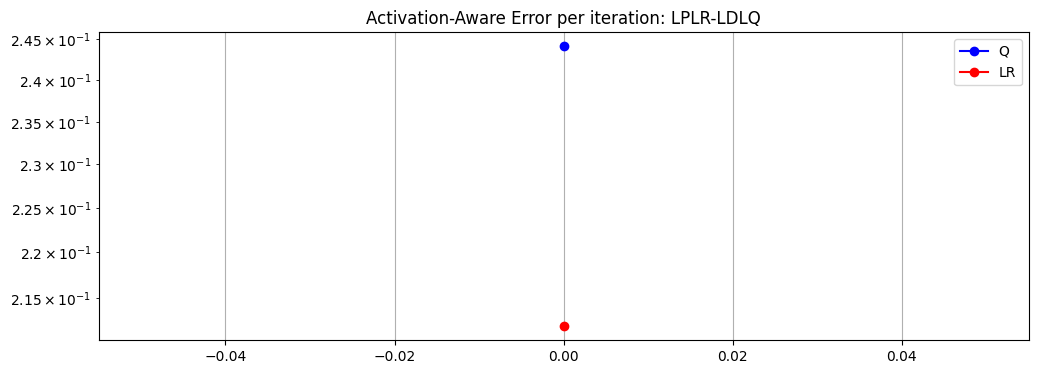

In [129]:
layer_quant.plot_errors(SUBLAYER)

In [148]:
quant_layer = layer_quant.get_quantized_linear_layer(SUBLAYER, ft_rank=0)

In [149]:
# generate some random data
X = torch.normal(torch.zeros(1, 4096, 4096), torch.ones(1, 4096, 4096)).to(DEVICE)
W_actual = layer_quant.sublayer_info[SUBLAYER].W.to(DEVICE)
W_hat = layer_quant.best_sublayer_info[SUBLAYER].Q + \
    layer_quant.best_sublayer_info[SUBLAYER].L @ layer_quant.best_sublayer_info[SUBLAYER].R

In [150]:
quant_layer.compare_outputs(X, W_hat)

8.0 64.0
8.0 172.0


0.0029115243814885616